# Polynomial Models (Scikit-Learn)

Preparing a mesh of XY points for "contour" plotting.  We'll assign values for some function to every point in the XY plane, using color to distinguish high and low values.

The function we'll use for that purpose is `distance_from_origin`.

In [1]:
import numpy as np

def distance_from_origin (X,Y):
    return np.sqrt(X**2 + Y**2)

inc,mn,mx = .01,-5,5

x = np.arange(mn,mx,inc)
y = np.arange(mn,mx,inc)
data_sz = x.shape[0]
X,Y = np.meshgrid(x,y)
#Z = sin_dist_distorted(X,Y)
Z = distance_from_origin(X,Y)

Preparing data for classifier training

In [2]:
#Points inside the circle of radius `radius` belong to the positive class (= True)
radius = 4
# Flatten the meshgrid
XR, YR, ZR = X.ravel(), Y.ravel(),Z.ravel()
#  XY is a data_sz x 2 matrix Each sample has two features 
XY = np.stack([XR,YR]).T
# Prepare classification "rule". 
B = Z <= radius
BR = B.ravel()

In [ ]:
#Train our linear regression classifier

In [15]:
# Actual module name from within python
from sklearn.linear_model import RidgeClassifier
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import metrics
import copy

def contourf(X,Y,Z, ax, cmap):
    #fig = plt.figure(figsize=(5,5))
    cmap=copy.copy(cmap)
    ax.contourf(X,Y,Z, cmap=cmap)

def polynomial_pipeline (X,y,include_bias = False, use_decision_function = False, degree = 60,
                        class_weight=None):
    poly = preprocessing.PolynomialFeatures(degree=degree, include_bias=include_bias)
    lin2 = RidgeClassifier(class_weight=class_weight)
    scaler = preprocessing.StandardScaler()
    pipeline_reg = pipeline.Pipeline([('poly', poly), ('scale', scaler), ('ridge', lin2)])
    pipeline_reg.fit(X, y)
    if use_decision_function:
        return pipeline_reg, pipeline_reg.decision_function(X)
    else:
        return pipeline_reg, pipeline_reg.predict(X)
             
def ridgeline_classifer (X,y, use_decision_function = False, class_weight=None):
    lin = RidgeClassifier(class_weight='balanced')
    lin.fit(X, y)
    if use_decision_function:
        return lin, lin.decision_function(X)
    else:
        return lin, lin.predict(X) 

Accuracy of Linear     50.12%
Accuracy of Polynomial 97.69%


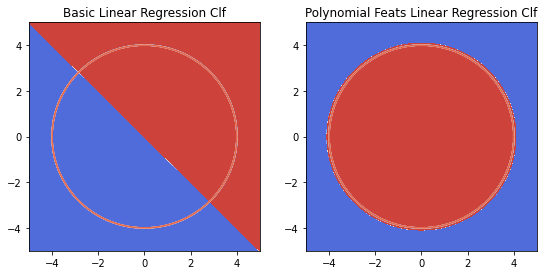

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm


##########################################
# Simple linear Ridge classifier
lin, curve = ridgeline_classifer (XY,BR)
#############################################


##########################################
# Ridge classifier with polynomial 
pipeline_reg2, curve2 = polynomial_pipeline (XY, BR, degree = 2)
##########################################

###############################################
# Configure Plot & Draw
###############################################

# Configure
scaler = .7
new_sz_array = scaler * np.array([(13,6)])
sz  = new_sz_array[0][0], new_sz_array[0][1]
fig = plt.figure(figsize=sz)
# 1 x 2 plot figure, plot 1
ax = fig.add_subplot(121)
ax.set_title('Basic Linear Regression Clf')
# 1 x 2 plot figure, plot 2
ax2 = fig.add_subplot(122)
ax2.set_title('Polynomial Feats Linear Regression Clf')
cmap=cm.coolwarm

# Draw linear classifier decisions
contourf(X,Y,curve.reshape((data_sz,data_sz)), ax, cmap)
# Draw B here to show true class boundary
line1 = ax.contour(X,Y,B, cmap=cmap)
print(f'Accuracy of Linear {metrics.accuracy_score(curve, BR): 10.2%}')
# Draw polynomial classifier decisions
contourf(X,Y,curve2.reshape((data_sz,data_sz)), ax2, cmap)
print(f'Accuracy of Polynomial {metrics.accuracy_score(curve2, BR):.2%}')
line2 = ax2.contour(X,Y,B, cmap=cmap)

The graph on the left is labeled "Basic Linear Regression Clf".  This seeks the best linear approximation (least squared error) to a function that assigns 1 to the points in the class and -1 to the points outside the class.  As defined in the previous cell, points inside a circle of radius 4.0 belong to the positive class.  This circle is shown in the graph.   There is a little extra math to this, but basically the Linear Regression Clf must define a straight line that separates the points inside the circle from those outside the circle.  Of course there is no such line.  The classifier does the best it can, which is to  draw a line that classifies half the points correctly (point in red are classified positive).  

It thus appears there is no linear classifier that can solve this problem.  However, that's not exactly right.
There is a very precise sense in which there is a linear classifier that solves the problem.   Here's
the idea.  We add new features to the model.  Recall that we start with 2-dimensional data (two features labeled x and y  for each sample).  We then pass the data through the following pipeline.

**Pipeline**


1.  Polynomial features. Generate a new feature matrix consisting of all polynomial combinations of the features 
    with degree less than or equal to 2. Our input samples are of the 
    form [a, b], the degree-2 (**quadratic**) polynomial features are [1, a, b, a^2, ab, b^2].  So we start with a 
    2-dimensional model [a,b] and end up with a 6-dimensional model.
   
2.  We then seek the coefficients that define the hyper plane that provides
    the least squared error solution for predicting the class.  
 
    $$
    class([a,b]) = c_1 + c_2a + c_3b + c_4a^2 + c_5ab + c_6b^2
    $$
 
    This is still a linear classifier
    model, just in more dimensions.  The learner finds a hyperplane defined by a linear function with 6 
    coefficients.  When we draw a plot with the 
    original two features as the X and Y axes and their quadratic combination as the predicted class, 
    the result is the picture on the right, with the points in red predicted to be positive and
    the points in blue predicted to be negative.  Using this
    trick, the learned "line"  is a circle that does an excellent job of
    separating positive points from negative points (97.7% accurate).

A closer look at the linear model.  The way the linear classifier decides which side of the boundary a particular point lies on is to compute its signed distance from the  boundary.  If that distance is positive we have a positive point; otherwise it's negative.  The function that computes the distance is called the **decision function**.  

The plot below uses the color map to show the values of the **decision function**. Brighter red means higher positive distance; brighter blue means high negative distance.  This can be interpreted as a confidence value.
Note the the confidence is entirely misplaced.  Confidence grows in the upper right as we move further **away** from the true class boundary.

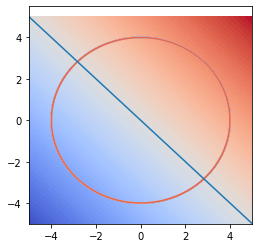

In [12]:
lin, curve = ridgeline_classifer (XY,BR, use_decision_function = True)
fig = plt.figure(figsize=(4,4))
# 1 x 1 plot figure, plot 1
ax = fig.add_subplot(111)
# Draw linear classifier decisions
ax.contourf(X,Y,curve.reshape((data_sz,data_sz)), 100, cmap=cmap)
# Draw B here to show true class boundary
line1 = ax.contour(X,Y,B, cmap=cmap)
ll = ax.plot(x,-x)

A closer look at the polynomial model.  We see a pretty good model.  The lightest area is where the model's class boundary is, so the learned boundary and the true boundary are distinct, but the model gets a lot right and will correctly classifying outliers with high confidence.

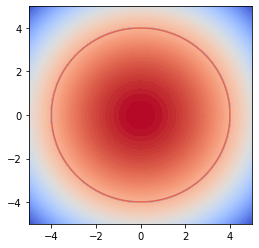

In [14]:

pipeline_reg2, curve2 = polynomial_pipeline (XY, BR, degree = 2,use_decision_function = True)
fig = plt.figure(figsize=(4,4))
# 1 x 1 plot figure, plot 1
ax = fig.add_subplot(111)
# Draw linear classifier decisions
ax.contourf(X,Y,curve2.reshape((data_sz,data_sz)), 100, cmap=cmap)
# Draw B here to show true class boundary
line1 = ax.contour(X,Y,B, cmap=cmap)